<a href="https://colab.research.google.com/github/KavinduJ2001/PR_A03/blob/main/PRA03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
import shutil
import random


In [4]:
# Base dataset path
dataset_path = "/content/drive/MyDrive/realwaste-main/RealWaste"

# Define paths for splits
base_dir = "/content/drive/MyDrive/realwaste-main/RealWaste_Split"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Create directories for train, val, test splits
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Create class subdirectories in each split folder
class_names = os.listdir(dataset_path)
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)


In [5]:
# Split ratio
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Iterate through each class folder
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)

    # Shuffle images randomly
    random.shuffle(images)

    # Calculate split indices
    train_count = int(len(images) * train_ratio)
    val_count = int(len(images) * val_ratio)

    # Split the dataset
    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Move files to their respective directories
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name))
    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_dir, class_name))
    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name))


In [6]:
def count_images(directory):
    total = 0
    for class_name in os.listdir(directory):
        total += len(os.listdir(os.path.join(directory, class_name)))
    return total

print(f"Training images: {count_images(train_dir)}")
print(f"Validation images: {count_images(val_dir)}")
print(f"Testing images: {count_images(test_dir)}")


Training images: 2848
Validation images: 949
Testing images: 955


In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Transforms
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to match input size
    transforms.ToTensor()
])

# Dataset
dataset = datasets.ImageFolder('/content/drive/MyDrive/realwaste-main/RealWaste', transform=transform)

# Splitting dataset
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self, x1=32, m1=3, x2=64, m2=3, x3=128, d=0.5, num_classes=9):
        """
        Args:
        - x1: Number of filters in the first convolutional layer
        - m1: Kernel size for the first convolutional layer
        - x2: Number of filters in the second convolutional layer
        - m2: Kernel size for the second convolutional layer
        - x3: Number of units in the fully connected layer
        - d: Dropout rate
        - num_classes: Number of output classes
        """
        super(BasicCNN, self).__init__()

        # First Convolutional Block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=x1, kernel_size=m1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Block
        self.conv2 = nn.Conv2d(in_channels=x1, out_channels=x2, kernel_size=m2, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(x2 * 8 * 8, x3)  # Assuming input images are 32x32
        self.dropout = nn.Dropout(p=d)
        self.fc2 = nn.Linear(x3, num_classes)

    def forward(self, x):
        # Forward pass through Convolutional and Pooling layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # Flatten the output and pass through fully connected layers
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        # Apply softmax to get class probabilities
        return F.log_softmax(x, dim=1)

# Example usage
model = BasicCNN(x1=32, m1=3, x2=64, m2=3, x3=128, d=0.5, num_classes=9)
print(model)


BasicCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)


Epoch 1/20, Train Loss: 2.2013, Val Loss: 2.1425
Epoch 2/20, Train Loss: 2.1522, Val Loss: 2.1394
Epoch 3/20, Train Loss: 2.1486, Val Loss: 2.1390
Epoch 4/20, Train Loss: 2.1474, Val Loss: 2.1417
Epoch 5/20, Train Loss: 2.1497, Val Loss: 2.1417
Epoch 6/20, Train Loss: 2.1497, Val Loss: 2.1394
Epoch 7/20, Train Loss: 2.1510, Val Loss: 2.1387
Epoch 8/20, Train Loss: 2.1501, Val Loss: 2.1376
Epoch 9/20, Train Loss: 2.1463, Val Loss: 2.1393
Epoch 10/20, Train Loss: 2.1476, Val Loss: 2.1388
Epoch 11/20, Train Loss: 2.1478, Val Loss: 2.1391
Epoch 12/20, Train Loss: 2.1489, Val Loss: 2.1386
Epoch 13/20, Train Loss: 2.1475, Val Loss: 2.1385
Epoch 14/20, Train Loss: 2.1465, Val Loss: 2.1379
Epoch 15/20, Train Loss: 2.1450, Val Loss: 2.1381
Epoch 16/20, Train Loss: 2.1498, Val Loss: 2.1383
Epoch 17/20, Train Loss: 2.1490, Val Loss: 2.1392
Epoch 18/20, Train Loss: 2.1491, Val Loss: 2.1396
Epoch 19/20, Train Loss: 2.1490, Val Loss: 2.1390
Epoch 20/20, Train Loss: 2.1499, Val Loss: 2.1391


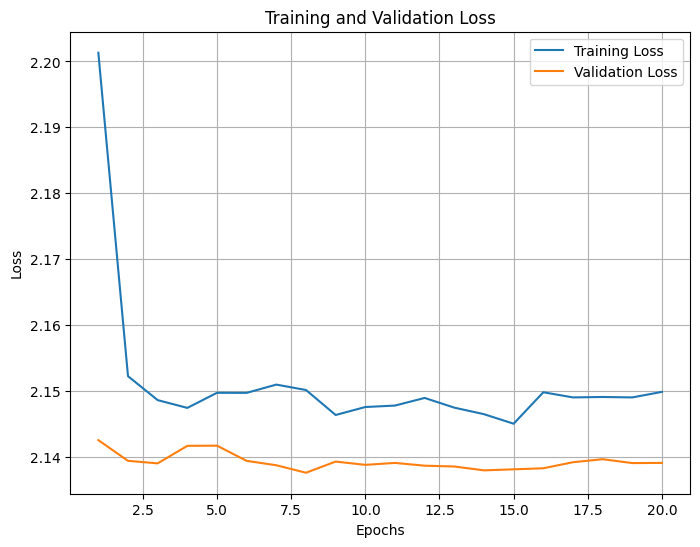

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Assuming the model is defined as `BasicCNN` and train_loader, val_loader are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model initialization
model = BasicCNN(x1=32, m1=3, x2=64, m2=3, x3=128, d=0.5, num_classes=9).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training and validation
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# Function to test the model
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the class index with max probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Append predictions and true labels for detailed analysis
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Generate classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.dataset.classes))

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

# Test the model
test_model(model, test_loader)


Test Accuracy: 19.87%

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.00      0.00      0.00        88
      Food Organics       0.00      0.00      0.00        79
              Glass       0.00      0.00      0.00        86
              Metal       0.00      0.00      0.00       171
Miscellaneous Trash       0.00      0.00      0.00        89
              Paper       0.00      0.00      0.00       101
            Plastic       0.20      1.00      0.33       189
      Textile Trash       0.00      0.00      0.00        70
         Vegetation       0.00      0.00      0.00        78

           accuracy                           0.20       951
          macro avg       0.02      0.11      0.04       951
       weighted avg       0.04      0.20      0.07       951


Confusion Matrix:
[[  0   0   0   0   0   0  88   0   0]
 [  0   0   0   0   0   0  79   0   0]
 [  0   0   0   0   0   0  86   0   0]
 [  0   0   0   0   0 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Second

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to dataset
data_dir = "/content/drive/MyDrive/realwaste-main/RealWaste"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes

# Split dataset (60% train, 20% val, 20% test)
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the CNN model
class RealWasteNet(nn.Module):
    def __init__(self):
        super(RealWasteNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Adjusted for 224x224 input size
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, len(class_names))  # Number of classes
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Initialize model, loss function, and optimizer
model = RealWasteNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Training the model
n_epochs = 20
train_loss_list, val_loss_list = [], []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Plot training and validation loss
plt.plot(range(1, n_epochs + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_loss_list, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Testing the model
model.eval()
true_labels, predicted_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {test_accuracy:.2%}")

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Confusion Matrix:\\n", conf_matrix)
print("Classification Report:\\n", class_report)


Epoch 1, Train Loss: 2.0586, Validation Loss: 1.8051
